In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
import networkx as nx
import community as community_louvain

En este proyecto se analiza la base de datos nndb_flat, vemos distintos alimentos clasificados por su tipo y su información nutricional.
Aplicamos un PCA y correlación de "Spearman" para tener un modelo mas robusto en varianza, asi mismo con la misma matriz de correlaciones formamos una red para posteriormente aplicar clustering de louvain.

El objetivo de este proyecto es simular los resultados en los que trabajo en mi tesis solo que en vez de tomar información nutricional tomamos datos fisiologicos para construir una "red fisiologica"

In [2]:
df = pd.read_csv("nndb_flat.csv")
display(df)

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876.0,0.28,99.48,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",NaN,NaN,NaN,353.0,21.40,28.74,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",NaN,NaN,NaN,371.0,23.24,29.68,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8613,83110,Finfish and Shellfish Products,"MACKEREL,SALTED","Fish, mackerel, salted",NaN,NaN,NaN,305.0,18.50,25.10,...,0.0375,0.206250,0.146154,0.016667,0.055000,0.000111,0.142857,0.362857,1.334545,0.100000
8614,90240,Finfish and Shellfish Products,"SCALLOP,(BAY&SEA),CKD,STMD","Mollusks, scallop, (bay and sea), cooked, steamed",NaN,NaN,NaN,111.0,20.54,0.84,...,0.0500,0.067250,0.018462,0.010000,0.008333,0.000037,0.088095,0.608571,0.394545,0.140909
8615,90480,Sweets,"SYRUP,CANE","Syrup, Cane",NaN,NaN,NaN,269.0,0.00,0.00,...,0.0000,0.006250,0.046154,0.108333,0.010833,0.000022,0.023810,0.011429,0.012727,0.017273
8616,90560,Finfish and Shellfish Products,"SNAIL,RAW","Mollusks, snail, raw",NaN,NaN,NaN,90.0,16.10,1.40,...,0.0150,0.087500,0.092308,0.008333,0.008333,0.000444,0.595238,0.388571,0.498182,0.090909


Revisamos la correlación entre las variables para comprobar que no hayan variables "redundantes" en nuestro modelo 

In [3]:
used = []
corrs = []
for i, j in enumerate(df.corr().columns):
    for k in range(len(df.corr(method = 'spearman'))):
        if ((df.corr().iloc[k, i] > 0.9) & 
            (j not in used) &
            (j != df.corr().index[k])):
            
            used.append(j)
            corrs.append((j, df.corr().index[k], 
                          np.round(df.corr().iloc[k, i], 2)))

            
corrsdf = pd.DataFrame([[i[0] for i in corrs],
                        [i[1] for i in corrs],
                        [i[2] for i in corrs]])

corrsdf = corrsdf.T.rename(columns = {0:'column',1:'row',2:'corr'})
corrsdf[:15]

,column,row,corr
0,VitA_mcg,VitA_USRDA,1.0
1,VitB6_mg,VitB6_USRDA,1.0
2,VitB12_mcg,VitB12_USRDA,1.0
3,VitC_mg,VitC_USRDA,1.0
4,VitE_mg,VitE_USRDA,1.0
5,Folate_mcg,Folate_USRDA,1.0
6,Niacin_mg,Niacin_USRDA,1.0
7,Riboflavin_mg,Riboflavin_USRDA,1.0
8,Thiamin_mg,Thiamin_USRDA,1.0
9,Calcium_mg,Calcium_USRDA,1.0


Notamos que las variables que tienen practicamente correlación de 1 terminan siendo las que tienen tienen terminación "USRDA", por lo tanto las quitamos de nuestro dataframe.

In [3]:
df.drop(df.columns[df.columns.str.contains('_USRDA')].values, 
        inplace=True, axis=1)

In [4]:
display(df)

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Riboflavin_mg,Thiamin_mg,Calcium_mg,Copper_mcg,Iron_mg,Magnesium_mg,Manganese_mg,Phosphorus_mg,Selenium_mcg,Zinc_mg
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717.0,0.85,81.11,...,0.034,0.005,24.0,0.000,0.02,2.0,0.000,24.0,1.0,0.09
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717.0,0.85,81.11,...,0.034,0.005,24.0,0.016,0.16,2.0,0.004,23.0,1.0,0.05
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876.0,0.28,99.48,...,0.005,0.001,4.0,0.001,0.00,0.0,0.000,3.0,0.0,0.01
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",NaN,NaN,NaN,353.0,21.40,28.74,...,0.382,0.029,528.0,0.040,0.31,23.0,0.009,387.0,14.5,2.66
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",NaN,NaN,NaN,371.0,23.24,29.68,...,0.351,0.014,674.0,0.024,0.43,24.0,0.012,451.0,14.5,2.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8613,83110,Finfish and Shellfish Products,"MACKEREL,SALTED","Fish, mackerel, salted",NaN,NaN,NaN,305.0,18.50,25.10,...,0.190,0.020,66.0,0.100,1.40,60.0,0.000,254.0,73.4,1.10
8614,90240,Finfish and Shellfish Products,"SCALLOP,(BAY&SEA),CKD,STMD","Mollusks, scallop, (bay and sea), cooked, steamed",NaN,NaN,NaN,111.0,20.54,0.84,...,0.024,0.012,10.0,0.033,0.58,37.0,0.029,426.0,21.7,1.55
8615,90480,Sweets,"SYRUP,CANE","Syrup, Cane",NaN,NaN,NaN,269.0,0.00,0.00,...,0.060,0.130,13.0,0.020,3.60,10.0,0.000,8.0,0.7,0.19
8616,90560,Finfish and Shellfish Products,"SNAIL,RAW","Mollusks, snail, raw",NaN,NaN,NaN,90.0,16.10,1.40,...,0.120,0.010,10.0,0.400,3.50,250.0,0.000,272.0,27.4,1.00


In [5]:

df.set_index('ID', inplace=True)
df_desc = df.iloc[:, :6]
df.drop(df.columns[:6].values, axis=1, inplace=True)

Empecemos con la "red" en este caso para delimitar el corte entre las variables que estan relacionadas aleatorizamos nuestras columnas para formar una "matriz aleatoria".

In [9]:
random_list = df.to_numpy().transpose().tolist()
for i in range(len(random_list)):
  random.shuffle(random_list[i])
print(random_list)

[[408.0, 31.0, 18.0, 195.0, 387.0, 126.0, 324.0, 529.0, 207.0, 391.0, 219.0, 179.0, 188.0, 159.0, 465.0, 75.0, 164.0, 241.0, 82.0, 48.0, 21.0, 215.0, 341.0, 195.0, 466.0, 85.0, 313.0, 459.0, 348.0, 400.0, 327.0, 477.0, 440.0, 220.0, 405.0, 381.0, 60.0, 196.0, 232.0, 234.0, 78.0, 475.0, 522.0, 32.0, 470.0, 51.0, 0.0, 202.0, 202.0, 540.0, 111.0, 350.0, 51.0, 75.0, 133.0, 63.0, 31.0, 16.0, 183.0, 354.0, 166.0, 297.0, 41.0, 391.0, 342.0, 23.0, 102.0, 143.0, 114.0, 58.0, 263.0, 21.0, 82.0, 884.0, 103.0, 22.0, 305.0, 122.0, 163.0, 184.0, 372.0, 165.0, 172.0, 376.0, 117.0, 128.0, 202.0, 57.0, 11.0, 41.0, 296.0, 21.0, 26.0, 264.0, 204.0, 37.0, 51.0, 408.0, 72.0, 145.0, 226.0, 106.0, 265.0, 237.0, 229.0, 111.0, 53.0, 24.0, 99.0, 255.0, 243.0, 130.0, 94.0, 40.0, 265.0, 161.0, 190.0, 6.0, 472.0, 32.0, 151.0, 50.0, 66.0, 122.0, 457.0, 364.0, 41.0, 125.0, 182.0, 146.0, 199.0, 713.0, 220.0, 430.0, 110.0, 298.0, 519.0, 259.0, 461.0, 229.0, 34.0, 97.0, 102.0, 389.0, 90.0, 297.0, 340.0, 376.0, 79.0, 35

In [10]:
new_df = {'Energy_kcal' : random_list[0],
          'Protein_g': random_list[1],
     'Fat_g' : random_list[2],
     'Carb_g' : random_list[3],
     'Sugar_g': random_list[4],
     'Fiber_g': random_list[5],
     'VitA_mcg': random_list[6],
     'VitB6_mg': random_list[7],
     'VitB12_mcg': random_list[8],
     'VitC_mg':random_list[9],
     'VitE_mg':random_list[10],
     'Folate_mcg':random_list[11],
     'Niacin_mg':random_list[12],
     'Riboflavin_mg':random_list[13],
     'Thiamin_mg':random_list[14],
     'Calcium_mg':random_list[15],
     'Copper_mcg':random_list[16],
     'Iron_mg':random_list[17],
     'Magnesium_mg':random_list[18],
     'Manganese_mg':random_list[19],
     'Phosphorus_mg':random_list[20],
     'Selenium_mcg':random_list[21],
     'Zinc_mg':random_list[22]
         }
new_df = pd.DataFrame(new_df)
display(new_df)

,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,...,Riboflavin_mg,Thiamin_mg,Calcium_mg,Copper_mcg,Iron_mg,Magnesium_mg,Manganese_mg,Phosphorus_mg,Selenium_mcg,Zinc_mg
0,408.0,0.37,0.45,14.44,10.83,0.0,0.0,2.050,0.00,0.0,...,0.203,0.000,26.0,0.386,1.80,25.0,0.354,0.0,0.0,0.00
1,31.0,14.57,12.20,16.49,0.00,0.0,0.0,0.000,0.00,0.0,...,0.030,0.140,16.0,0.091,0.57,338.0,0.619,79.0,9.8,1.33
2,18.0,6.50,1.23,9.57,37.14,0.0,0.0,0.050,1.41,6.9,...,0.046,0.154,409.0,0.320,3.38,24.0,0.000,214.0,42.1,0.59
3,195.0,28.03,0.30,22.66,1.63,1.0,0.0,0.142,2.00,20.0,...,0.080,0.044,68.0,0.126,0.90,5.0,0.395,35.0,9.0,0.00
4,387.0,14.73,14.59,0.00,0.56,3.2,0.0,0.277,0.36,0.0,...,0.015,0.519,57.0,0.101,2.20,14.0,0.000,183.0,5.2,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8613,173.0,6.50,3.30,0.00,0.49,2.1,317.0,0.166,1.70,3.5,...,0.000,0.095,51.0,0.000,24.00,22.0,0.000,224.0,0.5,0.00
8614,67.0,3.29,1.10,12.30,0.00,0.0,924.0,0.553,0.00,0.7,...,0.360,0.010,33.0,0.620,9.00,25.0,0.205,192.0,0.1,1.03
8615,362.0,14.86,0.10,8.95,31.70,2.2,0.0,0.041,0.00,1.8,...,0.059,0.010,137.0,0.131,0.50,25.0,0.030,0.0,1.2,0.49
8616,366.0,4.86,35.30,74.83,19.92,0.4,0.0,0.000,0.00,1.3,...,0.250,0.076,15.0,0.000,2.10,16.0,0.133,26.0,0.0,3.36


Con nuestra nueva matriz aleatoria realizamos correlacion de spearman y vemos cual es el valor maximo de la nueva matriz de correlaciones, este sera delimitado como nuestro corte

In [11]:
used = []
corrs = []
for i, j in enumerate(new_df.corr().columns):
    for k in range(len(new_df.corr(method = 'spearman'))):
        if ((new_df.corr().iloc[k, i] < 0.9) & 
            (j not in used) &
            (j != new_df.corr().index[k])):
            
            used.append(j)
            corrs.append((j,new_df.corr().index[k], 
                          new_df.corr().iloc[k, i], 2))

            
corrsdf = pd.DataFrame([[i[0] for i in corrs],
                        [i[1] for i in corrs],
                        [i[2] for i in corrs]])

corrsdf = corrsdf.T.rename(columns = {0:'column',1:'row',2:'corr'})

In [12]:
mayor = corrsdf.sort_values('corr', ascending = False)
mayor.head()

,column,row,corr
5,Fiber_g,Energy_kcal,0.020474
0,Energy_kcal,Protein_g,0.019505
1,Protein_g,Energy_kcal,0.019505
12,Niacin_mg,Energy_kcal,0.012286
19,Manganese_mg,Energy_kcal,0.005052


In [6]:
corr = df.corr(method = 'spearman')

El corte termina siendo en 0.02

In [17]:
df_mask_1 = corr >= 0.02
filtered_df_1 = corr[df_mask_1]
print(df_mask_1)

               Energy_kcal  Protein_g  Fat_g  Carb_g  Sugar_g  Fiber_g  \
Energy_kcal           True       True   True    True     True     True   
Protein_g             True       True   True   False    False    False   
Fat_g                 True       True   True   False    False    False   
Carb_g                True      False  False    True     True     True   
Sugar_g               True      False  False    True     True     True   
Fiber_g               True      False  False    True     True     True   
VitA_mcg             False      False  False   False     True    False   
VitB6_mg              True       True   True   False    False    False   
VitB12_mcg            True       True   True   False    False    False   
VitC_mg              False      False  False    True     True     True   
VitE_mg               True       True   True   False     True     True   
Folate_mcg            True       True  False    True     True     True   
Niacin_mg             True       True 

In [19]:
df_mask_1 = df_mask_1.replace({True: 1}, inplace=False)
df_mask_1 = df_mask_1.replace({False: 0}, inplace=False)
display(df_mask_1)

,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,...,Riboflavin_mg,Thiamin_mg,Calcium_mg,Copper_mcg,Iron_mg,Magnesium_mg,Manganese_mg,Phosphorus_mg,Selenium_mcg,Zinc_mg
Energy_kcal,1,1,1,1,1,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
Protein_g,1,1,1,0,0,0,0,1,1,0,...,1,1,1,1,1,1,0,1,1,1
Fat_g,1,1,1,0,0,0,0,1,1,0,...,1,1,1,1,1,1,0,1,1,1
Carb_g,1,0,0,1,1,1,0,0,0,1,...,0,1,1,1,1,1,1,0,0,0
Sugar_g,1,0,0,1,1,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,0
Fiber_g,1,0,0,1,1,1,0,0,0,1,...,0,1,1,1,1,1,1,0,0,0
VitA_mcg,0,0,0,0,1,0,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
VitB6_mg,1,1,1,0,0,0,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
VitB12_mcg,1,1,1,0,0,0,1,1,1,0,...,1,1,1,1,1,1,0,1,1,1
VitC_mg,0,0,0,1,1,1,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0


Guardamos el archivo 

In [ ]:
df_mask_1.to_csv('Matrix.csv')

In [7]:
matriz = pd.read_csv('Matrix.csv')

Con esta función realizaremos nuestra red

In [10]:
subnode = []
for i in range(23):
    subnode.append(i)
columns = ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g', 'Fiber_g',
       'VitA_mcg', 'VitB6_mg', 'VitB12_mcg', 'VitC_mg', 'VitE_mg',
       'Folate_mcg', 'Niacin_mg', 'Riboflavin_mg', 'Thiamin_mg', 'Calcium_mg',
       'Copper_mcg', 'Iron_mg', 'Magnesium_mg', 'Manganese_mg',
       'Phosphorus_mg', 'Selenium_mcg', 'Zinc_mg']

In [11]:
labels = {k:columns[k] for k in subnode} 

Con esta función creamos nuestro grafo y con el algoritmo de cluster de Louvain detectamos comunidades

[{0, 1, 2, 7, 8, 12, 13, 16, 17, 18, 20, 21, 22},
 {3, 4, 5, 6, 9, 10, 11, 14, 15, 19}]

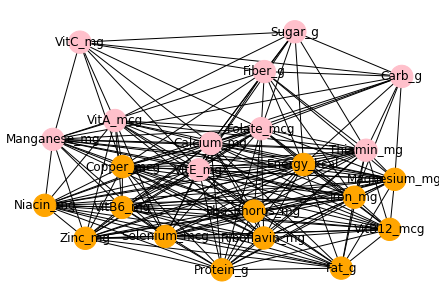

In [17]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    A = (0, 1, 2, 7, 8, 12, 13, 16, 17, 18, 20, 21, 22)
    B = (3, 4, 5, 6, 9, 10, 11, 14, 15, 19)
    color_map = []
    for node in gr:
        if node in A:
            color_map.append('orange')
        if node in B:
            color_map.append('pink')
    nx.draw(gr, node_size=500,labels = labels, with_labels=True,node_color = color_map )
    partition = nx.community.louvain_communities(gr, seed=123)
    return partition
    plt.show()

show_graph_with_labels(matriz)

Un analisis similar se hace sobre variables fisiologicas, estos analisis los realizo y se encuentran en el trabajo de grupo CALMECAC del centro de ciencias complejas UNAM